# TXT File Plotter
Goal: Plot a SeapHOx text file

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
from matplotlib.dates import DateFormatter

import os

from scipy import signal

In [2]:
df = pd.read_csv('Misc Data/ahl20200122.txt', header = 23, delimiter='\t', parse_dates=[1])
df.set_index('Sample Time', inplace=True)
start_row = 4+48*14 # first four samples are in air, next 14 days times 48 samples a day are conditioning
df = df.iloc[start_row:, :].copy() # few samples after turning SeapHOx on but before it was in the water
df.head()

,Sample #,Main Batt,Vtherm,Vint,Vext Ref,Iso Batt,Controller Temp,pH Temp,Pressure (dBar),pH Int,...,Substrate Leak,P/N,S/N,Oxygen uM,O2 Sat,Optode Temp,SBE Temp,Conductivity,Salinity,Unnamed: 22
Sample Time,,,,,,,,,,,,,,,,,,,,,
2020-02-05 17:30:25,#0000676,17.57,1.38434,0.069477,-0.873913,5.74,14.16,13.600,5.257,8.473570,...,1.2842,4835,496,300.746,92.960,13.770,13.7596,4.00471,33.4517,NaN
2020-02-05 18:00:25,#0000677,17.57,1.38228,0.069356,-0.874872,5.73,14.13,13.654,5.140,8.470894,...,1.2842,4835,496,301.636,93.436,13.867,13.8822,4.01824,33.4706,NaN
2020-02-05 18:30:25,#0000678,17.57,1.38074,0.070913,-0.875355,5.73,14.26,13.694,5.016,8.497844,...,1.2745,4835,496,301.877,93.564,13.893,13.8806,4.01952,33.4839,NaN
2020-02-05 19:00:25,#0000679,17.57,1.38123,0.068997,-0.875017,5.73,14.23,13.681,4.940,8.464312,...,1.2809,4835,496,302.527,93.698,13.860,13.8830,4.01484,33.4383,NaN
2020-02-05 19:30:25,#0000680,17.57,1.38681,0.070853,-0.871733,5.73,14.15,13.536,4.815,8.498412,...,1.2817,4835,496,309.646,95.529,13.683,13.6460,3.98464,33.3636,NaN


### Print all column labels

In [3]:
df.columns

Index(['Sample #', 'Main Batt', 'Vtherm', 'Vint', 'Vext Ref', 'Iso Batt',
       'Controller Temp', 'pH Temp', 'Pressure (dBar)', 'pH Int', 'pH Ext',
       'Counter Leak', 'Substrate Leak', 'P/N', 'S/N', 'Oxygen uM', 'O2 Sat',
       'Optode Temp', 'SBE Temp', 'Conductivity', 'Salinity', 'Unnamed: 22'],
      dtype='object')

### Correct oxygen using recorded salinity

In [4]:
# Correct O2 following Aanderaa salinity compensation calcs from manual
def correct_DO_with_sal(O2_uM, T_C, pressure, sal_meas, sal_input=0):
    '''
    Inputs
        O2_uM (µM): Dissolved oxygen recorded by Aanderaa with no salinity compensation applied
        T_C (ºC): Temperature measured by Aanderaa or auxiliary thermometer
        pressure (dbar): Pressure measured by auxiliary pressure sensor
        sal_meas (PSU): Salinity measured by auxiliary salinity/conductivity sensor
        sal_input (PSU): Salinity input into Aanderaa pre-deployment, usually 0
    '''
    
    # Coefficients from manual
    B0 = -0.00624097; B1 = -0.00693498; B2 = -0.00690358; B3 = -0.00429155;
    C0 = -0.00000031168
    Pcorr = 0.032
    
    # Calculations from manual
    Ts = np.log((298.15-T_C)/(273.15+T_C)) # scaled temp
    Sfctr = np.exp((sal_meas-sal_input)*(B0+B1*Ts+B2*Ts**2+B3*Ts**3))+C0*(sal_meas**2-sal_input**2)
    Pfctr = 1+np.abs(pressure)/1000*Pcorr
    O2_corr = O2_uM*Sfctr*Pfctr 

    return O2_corr

df['O2_corr uM'] = correct_DO_with_sal(df['Oxygen uM'], df['SBE Temp'], df['Pressure (dBar)'], df['Salinity'])

### Recalibrate pH based on k0 inputs (calculated by TWirth)

In [5]:
k0int_previous_deployment = -0.38484791
k0ext_previous_deployment =  -1.35771372

# Constants
# Universal gas constant, (R) , http://physics.nist.gov/cgi-bin/cuu/Value?r
R    = 8.31451          # J/(mol K)
F    = 96487            # Faraday constant Coulomb / mol

k2_int = -0.00125
k2_ext = -0.001048

def pHint_from_Vint_k0int(k0int, Vint, T_C):
    # See Martz et al. 2010, Bresnahan et al. 2014 for greater detail
    '''
    Inputs
        Internal ref voltage (V)
        Calibration coefficient, k0int (0 ºC value)
        Measured T (C)
    
    Outputs
        pHint (total scale)
    '''
    
    # Lumped, converted quantities
    T_K = T_C+273.15 # used often enough to warrant new variable
    S_Nernst = (R*T_K)/F*np.log(10) # ditto ^^^
    
    # Nernstian pH calculation
    pHint_tot = (Vint-(k0int+k2_int*(T_C-0)))/S_Nernst # Calc pHint from Nernst, the "-0" added explicitly intentionally
    
    return pHint_tot

def pHext_from_Vext_k0ext(k0ext, Vext, T_C, sal):
    # See Martz et al. 2010, Bresnahan et al. 2014 for greater detail
    '''
    Inputs
        External ref voltage (V)
        Calibration coefficient, k0ext (0 ºC value)
        Measured T (C)
        Salinity (PSU)
    
    Outputs
        pHext (total scale)
    '''
    
    # Lumped, converted quantities
    T_K = T_C+273.15 # used often enough to warrant new variable
    S_Nernst = (R*T_K)/F*np.log(10) # ditto ^^^
    
    # Physical chemistry calcs based on temp and salinity
    Z = 19.924*sal/(1000-1.005*sal) # Ionic strength, Dickson et al. 2007
    SO4_tot = (0.14/96.062)*(sal/1.80655) # Total conservative sulfate
    cCl = 0.99889/35.453*sal/1.80655 # Conservative chloride
    mCl = cCl*1000/(1000-sal*35.165/35) # mol/kg-H2O
    K_HSO4 = np.exp(-4276.1/T_K+141.328-23.093*np.log(T_K)
                    +(-13856/T_K+324.57-47.986*np.log(T_K))*Z**0.5
                    +(35474/T_K-771.54+114.723*np.log(T_K))*Z-2698/T_K*Z**1.5
                    +1776/T_K*Z**2+np.log(1-0.001005*sal)) # Bisulfate equilibrium const., Dickson et al. 2007
    DHconst = 0.00000343*T_C**2+0.00067524*T_C+0.49172143 # Debye-Huckel, Khoo et al. 1977
    log10gamma_HCl = 2*(-DHconst*np.sqrt(Z)/(1+1.394*np.sqrt(Z))+(0.08885-0.000111*T_C)*Z)
    
    # Nernstian pH calculations
    pHext_free = -(((k0ext+k2_ext*(T_C-0))-Vext)-S_Nernst*(np.log10(mCl)+log10gamma_HCl))/S_Nernst # mol/kg-H2O
    pHext_free = pHext_free-np.log10((1000-sal*35.165/35)/1000) # mol/kg-sw
    pHext_tot = pHext_free-np.log10(1+SO4_tot/K_HSO4)
    
    return pHext_tot

# Calculate pH_int and ext from various k0 inputs
df.loc[:, 'pH Int recalc'] = pHint_from_Vint_k0int(k0int_previous_deployment, df.loc[:, 'Vint'], df.loc[:, 'SBE Temp'])
df.loc[:, 'pH Ext recalc'] = pHext_from_Vext_k0ext(k0ext_previous_deployment, df.loc[:, 'Vext Ref'], df.loc[:, 'SBE Temp'], df.loc[:, 'Salinity'])

### Filter
- Filter based on date
- Filtration may come in handy later so keep this here for now

In [6]:
# date_filt = df.index > '2018-04-17 18:30:00'
# df = df[date_filt]

# pacific = pytz.timezone('US/Pacific')
# df.index = df.index.tz_localize(pytz.utc).tz_convert(pacific)
# df.head()

### Detrend pressure time-series
- Appears to be drifting toward a smaller (i.e., shallower) number
- This is sensor drift, presumably, so detrend
- HP filter code included but not implemented

In [7]:
# sampling_period_in_minutes = 30
# sampling_freq_in_Hz = 1/sampling_period_in_minutes/60

# hp_filter_length_days = 14

# order = 3
# Wn = 1/hp_filter_length_days/24/60/60 # cutoff freq in Hz based on desired filter length in days

# sos = signal.butter(order, Wn, 'hp', fs=sampling_freq_in_Hz, output='sos')
# df.loc[:, 'Pressure (dBar)'] = signal.sosfilt(sos, df.loc[:, 'Pressure (dBar)'])

mean_depth_prior_to_detrend = np.nanmean(df.loc[:, 'Pressure (dBar)'])
df.loc[:, 'Pressure (dBar)'] = signal.detrend(df.loc[:, 'Pressure (dBar)'])+mean_depth_prior_to_detrend

### Pull in rain data
- Supplied by K Shipley
- https://www.ncdc.noaa.gov/cdo-web/datasets/LCD/stations/WBAN:03177/detail__;!!Mih3wA!S3LQ-bTABpcng8as_md400UE7NX_theevJxwlVAxTX0bw_Ipnhgh278D8ooiSrWRoQ$

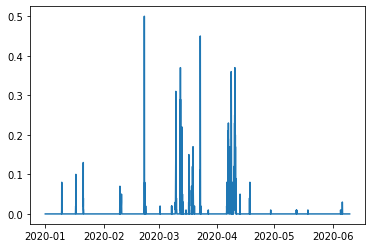

In [8]:
df_rain = pd.read_csv('Misc Data/2184690_rainfall_Data.csv', parse_dates = [1])
df_rain.set_index('DATE (LST)', inplace=True)

precip_num = pd.to_numeric(df_rain.loc[:, 'HourlyPrecipitation(in)'], errors='coerce').notnull()
df_rain = df_rain[precip_num]
precip = df_rain.loc[:, 'HourlyPrecipitation(in)'].astype(float)

fig, axs = plt.subplots()
axs.plot(precip.index, precip)

### Plot

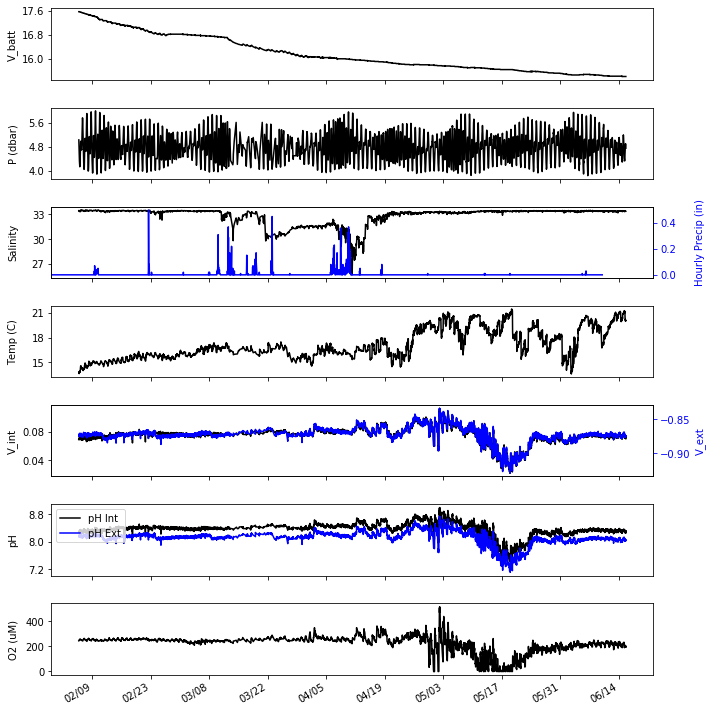

In [9]:
fig, axs = plt.subplots(7, 1, figsize = (10, 10), sharex = True)
axs[0].plot(df.index, df.loc[:, 'Main Batt'], 'k')
axs[0].set_ylabel('V_batt')
xmin, xmax = axs[0].get_xlim()

axs[1].plot(df.index, df.loc[:, 'Pressure (dBar)'], 'k')
axs[1].set_ylabel('P (dbar)')

axs[2].plot(df.index, df.loc[:, 'Salinity'], 'k')
axs[2].set_ylabel('Salinity')
ax2 = axs[2].twinx()
ax2.plot(precip.index, precip, 'b')
ax2.set_ylabel('Hourly Precip (in)', color='b')
ax2.tick_params('y', colors='b')

axs[3].plot(df.index, df.loc[:, 'SBE Temp'], 'k')
axs[3].set_ylabel('Temp (C)')

axs[4].plot(df.index, df.loc[:, 'Vint'], 'k')
axs[4].set_ylabel('V_int')
ax2 = axs[4].twinx()
ax2.plot(df.index, df.loc[:, 'Vext Ref'], 'b')
ax2.set_ylabel('V_ext', color='b')
ax2.tick_params('y', colors='b')

axs[5].plot(df.index, df.loc[:, 'pH Int recalc'], 'k', label = 'pH Int')
axs[5].plot(df.index, df.loc[:, 'pH Ext recalc'], 'b', label = 'pH Ext')
axs[5].legend(loc='upper left')
axs[5].set_ylabel('pH')

axs[6].plot(df.index, df.loc[:, 'O2_corr uM'], 'k')
axs[6].set_ylabel('O2 (uM)')

axs[0].xaxis_date() # make sure it knows that x is a date/time

for axi in axs.flat:
#     axi.xaxis.set_major_locator(plt.MaxNLocator(3))
#     print(axi)
    axi.yaxis.set_major_locator(plt.MaxNLocator(3))
#     axi.yaxis.set_major_formatter(ticker.FormatStrFormatter("%.02f"))

# xtick dates are poorly spaced
axs[0].set_xlim([xmin, xmax])
axs[0].xaxis.set_major_locator(ticker.MultipleLocator(14))

date_form = DateFormatter("%m/%d")
axs[0].xaxis.set_major_formatter(date_form)

fig.autofmt_xdate() # makes the date labels easier to read.
fig.align_ylabels()
plt.tight_layout()
plt.savefig('AHL_2020_BloomDieoff_light.png', dpi = 600)

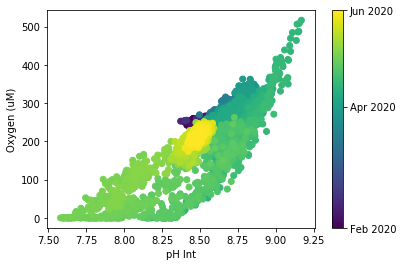

In [10]:
# end_date = pd.to_datetime('2018-06-25').tz_localize(pacific)
# good_dates = df.index < end_date
# df_good_dates = pd.DataFrame(df[good_dates])

# Plot prop-prop with time as color
fig2 = plt.figure()
im = plt.scatter(df.loc[:, 'pH Int'], df.loc[:, 'O2_corr uM'], c = df.index)
plt.ylabel('Oxygen (uM)')
plt.xlabel('pH Int')

# Set up colorbar tick labels
n_ticks = 3
indexes = [df.index[i] for i in np.linspace(0, df.shape[0]-1, n_ticks).astype(int)] 
cb = fig2.colorbar(im, orientation='vertical',
                   ticks= df.loc[indexes].index.astype(int))
cb.ax.set_yticklabels([index.strftime('%b %Y') for index in indexes])

plt.show()

### Make a better fig for presentations

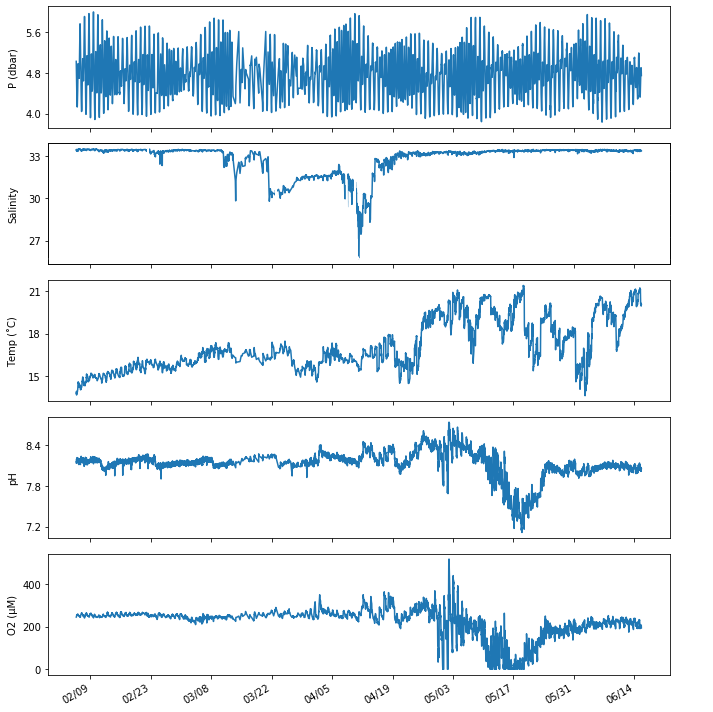

In [11]:
# plt.style.use('dark_background')
fig, axs = plt.subplots(5, 1, figsize = (10, 10), sharex = True)

axs[0].plot(df.index, df.loc[:, 'Pressure (dBar)'])#, 'k')
axs[0].set_ylabel('P (dbar)')
xmin, xmax = axs[0].get_xlim()

axs[1].plot(df.index, df.loc[:, 'Salinity'])#, 'k')
axs[1].set_ylabel('Salinity')
ax2 = axs[1].twinx()
ax2.plot(precip.index, precip, 'w')
ax2.set_ylabel('Hourly Precip (in)', color='w')
ax2.tick_params('y', colors='w')

axs[2].plot(df.index, df.loc[:, 'SBE Temp'])#, 'k')
axs[2].set_ylabel('Temp (˚C)')

axs[3].plot(df.index, df.loc[:, 'pH Ext recalc'])#, 'k', label = 'pH Ext')
axs[3].set_ylabel('pH')

axs[4].plot(df.index, df.loc[:, 'O2_corr uM'])#, 'k')
axs[4].set_ylabel('O2 (µM)')

axs[0].xaxis_date() # make sure it knows that x is a date/time

for axi in axs.flat:
#     axi.xaxis.set_major_locator(plt.MaxNLocator(3))
#     print(axi)
    axi.yaxis.set_major_locator(plt.MaxNLocator(3))
#     axi.yaxis.set_major_formatter(ticker.FormatStrFormatter("%.02f"))

axs[0].set_xlim([xmin, xmax])
# xtick dates are poorly spaced
axs[0].xaxis.set_major_locator(ticker.MultipleLocator(14))

date_form = DateFormatter("%m/%d")
axs[0].xaxis.set_major_formatter(date_form)

fig.autofmt_xdate() # makes the date labels easier to read.
plt.tight_layout()
fig.align_ylabels()

plt.savefig('AHL_2020_BloomDieoff.png', dpi = 600)

### Zoom in to see bloom in detail

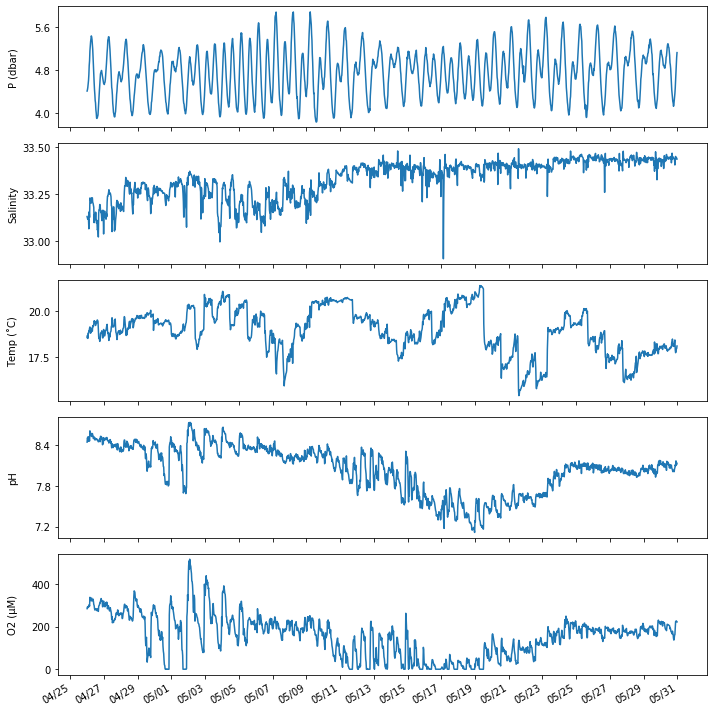

In [12]:
date_filt = (df.index > '2020-04-26 00:00:00') & (df.index < '2020-05-31 00:00:00')
df_filt = df[date_filt]

fig, axs = plt.subplots(5, 1, figsize = (10, 10), sharex = True)

axs[0].plot(df_filt.index, df_filt.loc[:, 'Pressure (dBar)'])#, 'k')
axs[0].set_ylabel('P (dbar)')

axs[1].plot(df_filt.index, df_filt.loc[:, 'Salinity'])#, 'k')
axs[1].set_ylabel('Salinity')
# axs[2].set_ylim([33.3, 34.3])

axs[2].plot(df_filt.index, df_filt.loc[:, 'SBE Temp'])#, 'k')
axs[2].set_ylabel('Temp (˚C)')

axs[3].plot(df_filt.index, df_filt.loc[:, 'pH Ext recalc'])#, 'k', label = 'pH Ext')
axs[3].set_ylabel('pH')

axs[4].plot(df_filt.index, df_filt.loc[:, 'O2_corr uM'])#, 'k')
axs[4].set_ylabel('O2 (µM)')

axs[0].xaxis_date() # make sure it knows that x is a date/time

for axi in axs.flat:
#     axi.xaxis.set_major_locator(plt.MaxNLocator(3))
#     print(axi)
    axi.yaxis.set_major_locator(plt.MaxNLocator(3))
#     axi.yaxis.set_major_formatter(ticker.FormatStrFormatter("%.02f"))

# xtick dates are poorly spaced
axs[0].xaxis.set_major_locator(ticker.MultipleLocator(2))

date_form = DateFormatter("%m/%d")
axs[0].xaxis.set_major_formatter(date_form)

fig.autofmt_xdate() # makes the date labels easier to read.
plt.tight_layout()
fig.align_ylabels()

plt.savefig('AHL_2020_BloomDieoff_zoom.png', dpi = 600)

In [13]:
df.to_csv('Misc Data/AHL_SeapHOx_processed_2020-06-15.csv')